# Reproduction code for the figure 2 (supplementary information) : locating the uncertainty in the distribution 

In [1]:
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd 
import torch.nn.functional as F
import copy
from scipy.stats import norm
import random
from tqdm import tqdm


import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from functions.eqrdqn_functions import *

#### Set device

In [3]:
USE_CUDA = torch.cuda.is_available()
Variable = lambda *args, **kwargs: autograd.Variable(*args, **kwargs).cuda() if USE_CUDA else autograd.Variable(*args, **kwargs)

In [6]:
n_nets = 50
r = [1 for j in range(50)] + [-1 for j in range(50)]
r = torch.FloatTensor(r)
l2_reg = 5
num_quant = 50
mean_prior = 0
std_prior = .2
lr = 1e-3


In [7]:
# current_models_r = []
# uncertainty_non_stationarity = []

current_models = []
target_models = []
optimizers = []

# Init networks
for i in range(n_nets):
    current_models.append(QRContext(1,
                                1,
                                num_quant,
                                mean_prior=mean_prior,
                                std_prior=std_prior,
                                l2_reg=l2_reg))

    target_models.append(QRContext(1,
                                    1,
                                    num_quant,
                                    mean_prior=mean_prior,
                                    std_prior=std_prior,
                                    l2_reg=l2_reg))

    optimizers.append(optim.Adam(current_models[-1].parameters(), lr=lr))



for epoch in range(tqdm(100)):

    for i in range(n_nets):


        action     = Variable(torch.LongTensor([0 for j in range(len(r))]))

        train_step(current_models[i],
                   target_models[i],
                   optimizers[i],
                   torch.tensor([[1] for i in range(len(r))]),
                   action,
                   r,
                  n_samples=epoch,
                num_quant=50,
                  anchored=True)


(array([-2. , -1.5, -1. , -0.5,  0. ,  0.5,  1. ,  1.5,  2. ,  2.5]),
 <a list of 10 Text yticklabel objects>)

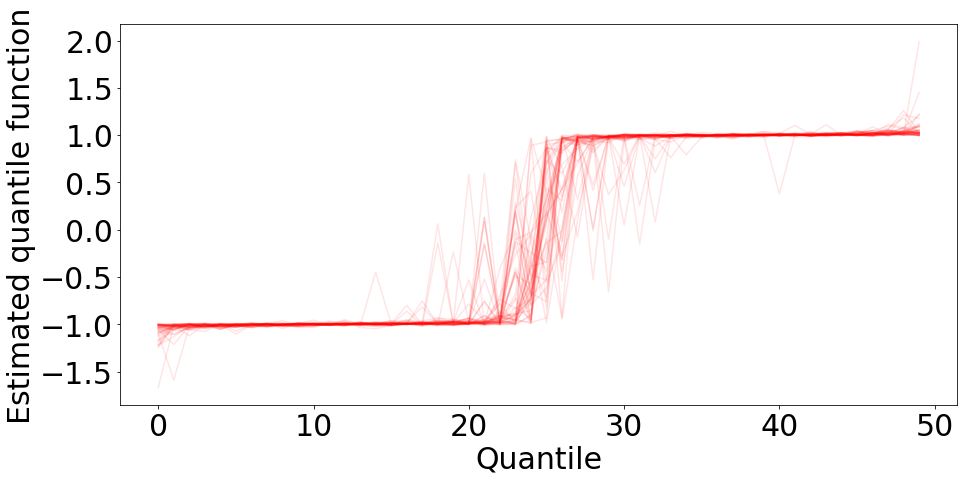

In [8]:
# For 50 networks
plt.figure(figsize=(15,7))
for i in range(len(current_models)):
    plt.plot(current_models[i](torch.tensor([1])).detach().squeeze().numpy(), alpha=0.1, c='r')

plt.xlabel("Quantile", fontsize=30)
plt.ylabel("Estimated quantile function", fontsize=30)
plt.xticks(size=(30))
plt.yticks(size=(30))

In [9]:
uncertainties = []
for i in range(len(current_models)):
    for j in range(i):
        d1 = current_models[i](torch.tensor([1])).detach().squeeze().numpy()
        d2 = current_models[j](torch.tensor([1])).detach().squeeze().numpy()
        uncertainties.append(np.abs(d1-d2))
        

(array([-0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8]),
 <a list of 10 Text yticklabel objects>)

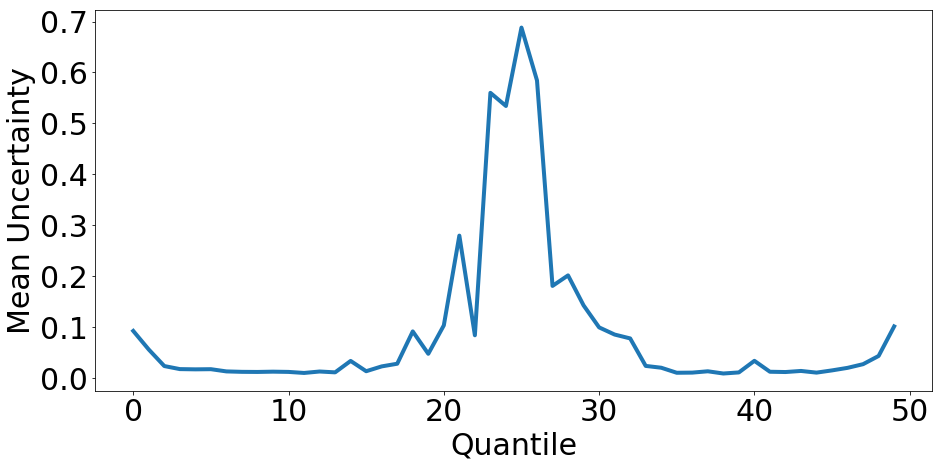

In [10]:
plt.figure(figsize=(15,7))
plt.plot(np.stack(uncertainties).mean(0), linewidth=4)
plt.xlabel("Quantile", fontsize=30)
plt.ylabel("Mean Uncertainty", fontsize=30) # Calculated between couple of networks
plt.xticks(size=(30))
plt.yticks(size=(30))